In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
nltk.download('stopwords')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

EDA

RNN

In [ ]:
my_data=pd.read_csv("Tweets.csv")

def clean_text(text):
    text = re.sub(r'http\S+', '', text)   # Remove URLs
    text = re.sub(r'<.*?>', '', text)     # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)   # Remove punctuation and special chars
    text = text.lower()                   # Convert to lowercase
    # Remove stopwords
    #text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    return text

my_data['cleaned_text'] = my_data['text'].apply(clean_text)
# Cleaning http links in Dataframes
url_pattern = r'http[s]?://\S+'

# Replace URLs with an empty string
my_data['cleaned_text'] = my_data['cleaned_text'].str.replace(url_pattern, '', regex=True)
#tweets[tweets["text"].str.contains("http")]
#tweets.shape

my_data.drop_duplicates(subset = "cleaned_text", keep = "last", inplace = True)

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(my_data['cleaned_text'])
sequences = tokenizer.texts_to_sequences(my_data['cleaned_text'])

# Define maximum sequence length
max_seq_length = max([len(x) for x in sequences])
word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')

data = pad_sequences(sequences, maxlen=max_seq_length)

le = LabelEncoder()
my_data['sentiment'] = le.fit_transform(my_data['airline_sentiment'])

labels = my_data['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


Found 15527 unique tokens.


In [ ]:
import tensorflow as tf
import numpy as np
import random
import os
from tensorflow.keras.callbacks import ReduceLROnPlateau
# Set a seed value
seed_value = 42

# 1. Set the `PYTHONHASHSEED` environment variable to a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set the `python` built-in pseudo-random generator to a fixed value
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator to a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator to a fixed value
tf.random.set_seed(seed_value)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

vocab_size = len(word_index) + 1  # Adding 1 because of reserved 0 index
embedding_dim = 100

# Adjusted model parameters
dropout_rate = 0.7  # Increased dropout rate
l2_reg_strength = 0.001  # Reduced L2 regularization strength
rnn_units = 50  # Reduced number of LSTM units for simplicity

# Create the RNN model
rnn_model = Sequential()
rnn_model.add(Embedding(vocab_size, embedding_dim, input_length=max_seq_length))
rnn_model.add(LSTM(rnn_units, return_sequences=True, kernel_regularizer=l2(l2_reg_strength)))
rnn_model.add(Dropout(dropout_rate))
rnn_model.add(LSTM(rnn_units, kernel_regularizer=l2(l2_reg_strength)))
rnn_model.add(Dropout(dropout_rate))
rnn_model.add(Dense(3, activation='softmax'))

# Optimizer
optimizer = Adam(learning_rate=0.0005)

# Compile the model
rnn_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Learning Rate Scheduler
decay_rate = 0.05
lr_schedule = LearningRateScheduler(lambda epoch: 0.0005 * np.exp(-decay_rate * epoch))

# Train the model with early stopping and learning rate scheduler
rnn_history = rnn_model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_schedule, reduce_lr]
)



Epoch 1/10
358/358 [==============================] - 40s 92ms/step - loss: 0.8528 - accuracy: 0.6768 - val_loss: 0.6747 - val_accuracy: 0.7251 - lr: 5.0000e-04
Epoch 2/10
358/358 [==============================] - 31s 88ms/step - loss: 0.5894 - accuracy: 0.7776 - val_loss: 0.6214 - val_accuracy: 0.7569 - lr: 4.7561e-04
Epoch 3/10
358/358 [==============================] - 26s 72ms/step - loss: 0.4453 - accuracy: 0.8494 - val_loss: 0.5965 - val_accuracy: 0.7862 - lr: 4.5242e-04
Epoch 4/10
358/358 [==============================] - 26s 72ms/step - loss: 0.3548 - accuracy: 0.8906 - val_loss: 0.6478 - val_accuracy: 0.7754 - lr: 4.3035e-04
Epoch 5/10
358/358 [==============================] - 24s 67ms/step - loss: 0.2884 - accuracy: 0.9170 - val_loss: 0.7228 - val_accuracy: 0.7796 - lr: 4.0937e-04
Epoch 6/10
358/358 [==============================] - 26s 72ms/step - loss: 0.2450 - accuracy: 0.9342 - val_loss: 0.7618 - val_accuracy: 0.7702 - lr: 3.8940e-04


In [ ]:
test_loss, test_accuracy = rnn_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")


90/90 [==============================] - 1s 13ms/step - loss: 0.5965 - accuracy: 0.7862
Test Accuracy: 0.7862381935119629


In [ ]:
from sklearn.metrics import f1_score

# Calculate F1 score
f1 = f1_score(y_test, y_pred_rnn_classes, average='weighted')  # 'weighted' accounts for label imbalance
print("F1 Score: ", f1)


F1 Score:  0.7805034585403529


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize the output for each class
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])  # Adjust classes based on your dataset

# Predict probabilities for each class
y_pred_prob = rnn_model.predict(X_test)

# Calculate ROC AUC Score using One-vs-All method
roc_auc_ovr = roc_auc_score(y_test_binarized, y_pred_prob, multi_class='ovr')

print("ROC AUC Score (One-vs-All): ", roc_auc_ovr)


90/90 [==============================] - 2s 19ms/step
ROC AUC Score (One-vs-All):  0.8899206154052729


In [ ]:
from sklearn.metrics import log_loss

# Calculate Log-Loss
logloss = log_loss(y_test_binarized, y_pred_prob)
print("Log-Loss: ", logloss)


Log-Loss:  0.5578556812690147


90/90 [==============================] - 4s 23ms/step


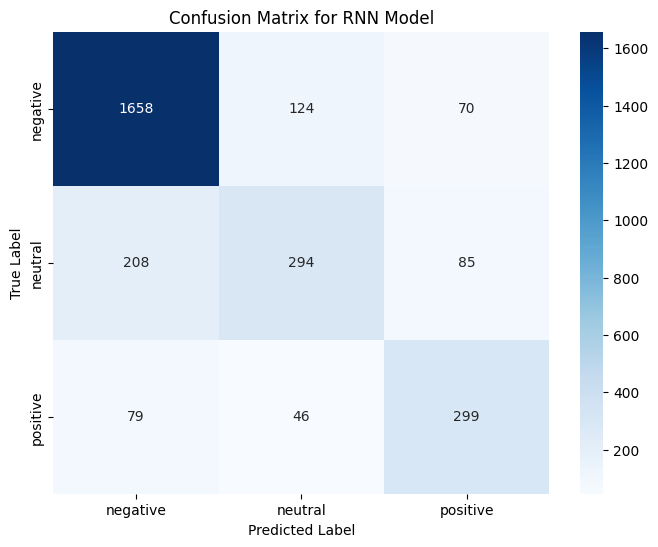

In [ ]:
# Predict classes on the test set
y_pred_rnn = rnn_model.predict(X_test)
y_pred_rnn_classes = np.argmax(y_pred_rnn, axis=1)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the confusion matrix
cm_rnn = confusion_matrix(y_test, y_pred_rnn_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rnn, annot=True, fmt="d", cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix for RNN Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Save the plot with a transparent background
plt.savefig('confusion_matrix_transparent.png', transparent=True)

plt.show()


90/90 [==============================] - 3s 30ms/step


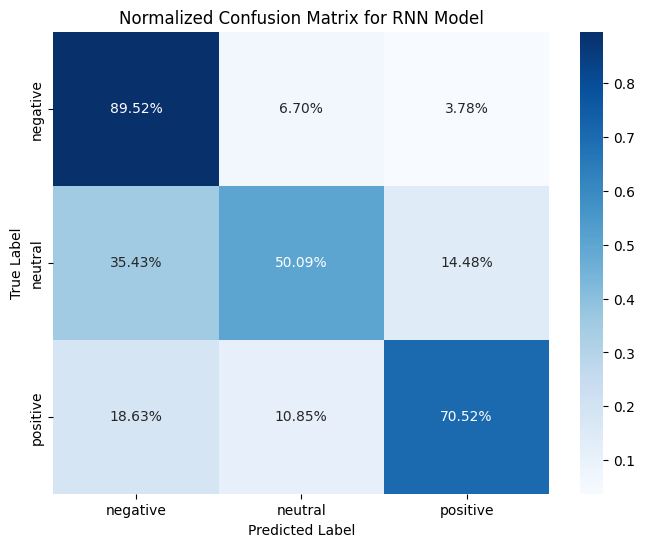

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict classes on the test set
y_pred_rnn = rnn_model.predict(X_test)
y_pred_rnn_classes = np.argmax(y_pred_rnn, axis=1)

# Compute the normalized confusion matrix
cm_rnn = confusion_matrix(y_test, y_pred_rnn_classes, normalize='true')  # Normalizing by true labels

# Plot the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rnn, annot=True, fmt=".2%", cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Normalized Confusion Matrix for RNN Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Save the plot with a transparent background
plt.savefig('confusion_matrix_transparent3.png', transparent=True)

plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set a seed value
seed_value = 42

# 1. Set the `PYTHONHASHSEED` environment variable to a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set the `python` built-in pseudo-random generator to a fixed value
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator to a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator to a fixed value
tf.random.set_seed(seed_value)

# CNN Model parameters
num_filters = 50  # Number of convolutional filters
kernel_size = 3   # Size of the convolutional kernels
dropout_rate = 0.7  # Same as in the RNN model
l2_reg_strength = 0.0001  # Same L2 regularization strength

# Create the CNN model
cnn_model = Sequential()
cnn_model.add(Embedding(vocab_size, embedding_dim, input_length=max_seq_length))
cnn_model.add(Conv1D(num_filters, kernel_size, activation='relu', kernel_regularizer=l2(l2_reg_strength)))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dropout(dropout_rate))
cnn_model.add(Dense(3, activation='softmax', kernel_regularizer=l2(l2_reg_strength)))  # Assuming 3 classes

# Optimizer
optimizer = Adam(learning_rate=0.0005)

# Compile the model
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Train the model with early stopping and learning rate reduction
cnn_history = cnn_model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr]
)




Epoch 1/10
358/358 [==============================] - 10s 27ms/step - loss: 0.9037 - accuracy: 0.6227 - val_loss: 0.7610 - val_accuracy: 0.6752 - lr: 5.0000e-04
Epoch 2/10
358/358 [==============================] - 9s 26ms/step - loss: 0.7170 - accuracy: 0.7139 - val_loss: 0.6123 - val_accuracy: 0.7586 - lr: 5.0000e-04
Epoch 3/10
358/358 [==============================] - 15s 43ms/step - loss: 0.6079 - accuracy: 0.7712 - val_loss: 0.5625 - val_accuracy: 0.7876 - lr: 5.0000e-04
Epoch 4/10
358/358 [==============================] - 12s 34ms/step - loss: 0.5310 - accuracy: 0.8114 - val_loss: 0.5410 - val_accuracy: 0.8016 - lr: 5.0000e-04
Epoch 5/10
358/358 [==============================] - 10s 28ms/step - loss: 0.4725 - accuracy: 0.8425 - val_loss: 0.5340 - val_accuracy: 0.8054 - lr: 5.0000e-04
Epoch 6/10
358/358 [==============================] - 9s 24ms/step - loss: 0.4134 - accuracy: 0.8634 - val_loss: 0.5385 - val_accuracy: 0.8048 - lr: 5.0000e-04
Epoch 7/10
358/358 [================

In [ ]:
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")


Exception ignored in: <function _xla_gc_callback at 0x7a56697ec670>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 101, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


90/90 [==============================] - 0s 3ms/step - loss: 0.5340 - accuracy: 0.8054
Test Accuracy: 0.8054488301277161


In [ ]:
from sklearn.metrics import f1_score

# Calculate F1 score
f1 = f1_score(y_test, y_pred_cnn_classes, average='weighted')  # 'weighted' accounts for label imbalance
print("F1 Score: ", f1)


F1 Score:  0.7932270499328954


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize the output for each class
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])  # Adjust classes based on your dataset

# Predict probabilities for each class
y_pred_prob = cnn_model.predict(X_test)

# Calculate ROC AUC Score using One-vs-All method
roc_auc_ovr = roc_auc_score(y_test_binarized, y_pred_prob, multi_class='ovr')

print("ROC AUC Score (One-vs-All): ", roc_auc_ovr)

90/90 [==============================] - 0s 4ms/step
ROC AUC Score (One-vs-All):  0.8943495588025788


In [ ]:
from sklearn.metrics import log_loss

# Calculate Log-Loss
logloss = log_loss(y_test_binarized, y_pred_prob)
print("Log-Loss: ", logloss)

Log-Loss:  0.5281869817221164


90/90 [==============================] - 0s 5ms/step


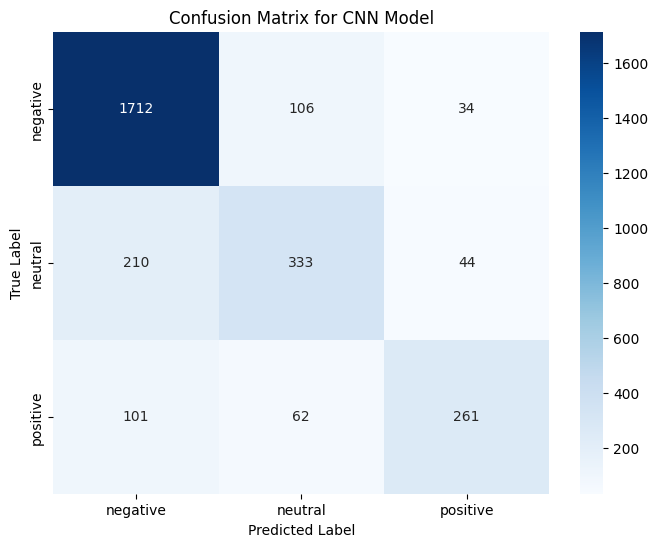

In [ ]:
# Predict classes on the test set
y_pred_cnn = cnn_model.predict(X_test)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the confusion matrix
cm_cnn = confusion_matrix(y_test, y_pred_cnn_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt="d", cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix for CNN Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
# Show the plot

# Save the plot with a transparent background
plt.savefig('confusion_matrix_transparent.png', transparent=True)

plt.show()


90/90 [==============================] - 1s 7ms/step


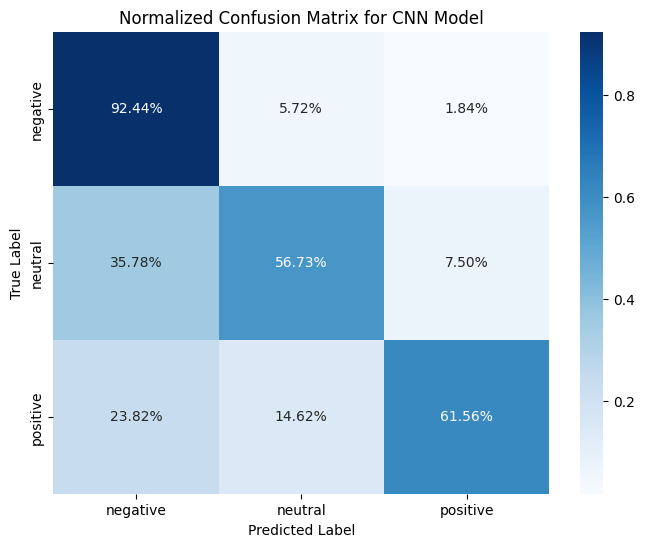

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict classes on the test set
y_pred_cnn = cnn_model.predict(X_test)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)

# Compute the normalized confusion matrix
cm_cnn = confusion_matrix(y_test, y_pred_cnn_classes, normalize='true')  # Normalizing by true labels

# Plot the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt=".2%", cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Normalized Confusion Matrix for CNN Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Save the plot with a transparent background
plt.savefig('confusion_matrix_transparent2.png', transparent=True)

plt.show()


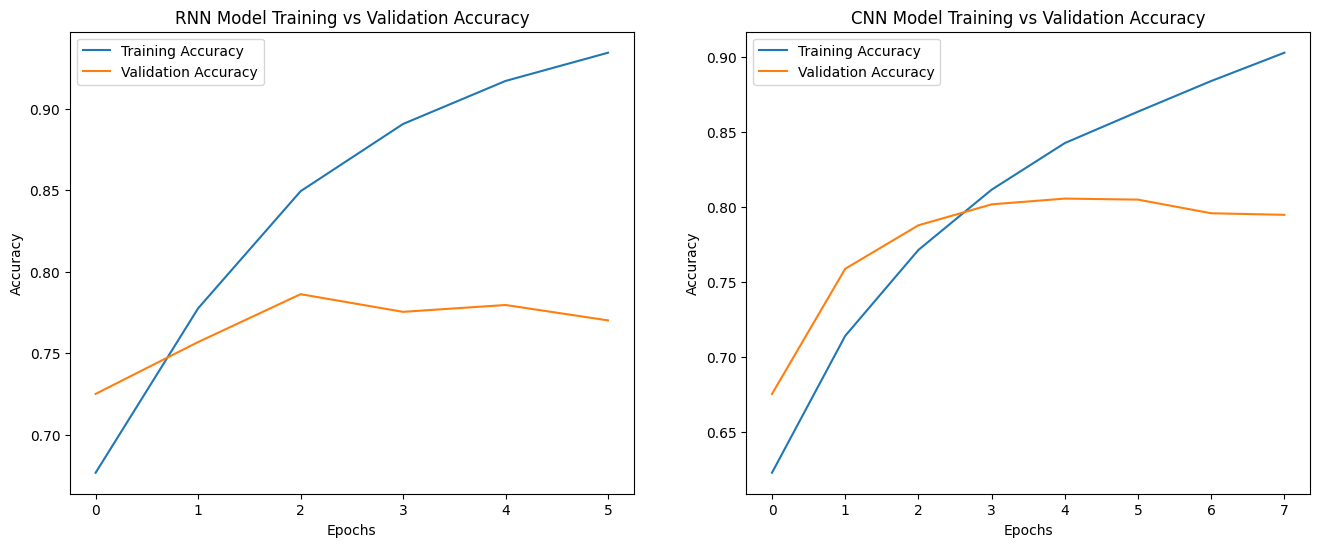

In [ ]:
import matplotlib.pyplot as plt

# Function to plot accuracy on a given subplot
def plot_accuracy_subplot(history, title, ax):
    ax.plot(history.history['accuracy'], label='Training Accuracy')
    ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax.set_title(title)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.legend()

# Create a figure and a set of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot accuracy for RNN model on the first subplot
plot_accuracy_subplot(rnn_history, 'RNN Model Training vs Validation Accuracy', ax1)

# Plot accuracy for CNN model on the second subplot
plot_accuracy_subplot(cnn_history, 'CNN Model Training vs Validation Accuracy', ax2)

# Show the plot
plt.show()


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Vectorize the cleaned text data
tfidf =  TfidfVectorizer(min_df=5, max_df=0.8, sublinear_tf=True, use_idf=True, ngram_range=(1,1))  # Adjust max_features as needed
X_vectorized = tfidf.fit_transform(my_data['cleaned_text']).toarray()

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(my_data['airline_sentiment'])

# Split the data into training and testing sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_vectorized, y_encoded, test_size=0.2, random_state=42)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Random Forest model
rf = RandomForestClassifier()

# Grid of parameters to search over
param_grid = {
    'n_estimators': [100, 200],
    'max_features':  ['sqrt'],
    'max_depth': [10, 20],
    'min_samples_split': [2, 4],
}

# Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=3)
grid_search.fit(X_train_rf, y_train_rf)


Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 20], 'max_features': ['sqrt'],
                         'min_samples_split': [2, 4],
                         'n_estimators': [100, 200]},
             verbose=3)

In [ ]:
# Evaluate the best model
best_rf = grid_search.best_estimator_
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

# Predict on the test set
y_pred_rf = best_rf.predict(X_test_rf)

# Evaluate the predictions
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

print("Accuracy on Test Set: ", accuracy_score(y_test_rf, y_pred_rf))
print("Classification Report:\n", classification_report(y_test_rf, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test_rf, y_pred_rf))


Best parameters found:  {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
Best score found:  0.6768841149244608
Accuracy on Test Set:  0.6800558854348585
Classification Report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80      1852
           1       0.79      0.06      0.10       587
           2       0.89      0.16      0.27       424

    accuracy                           0.68      2863
   macro avg       0.78      0.40      0.39      2863
weighted avg       0.73      0.68      0.58      2863

Confusion Matrix:
 [[1846    4    2]
 [ 548   33    6]
 [ 351    5   68]]


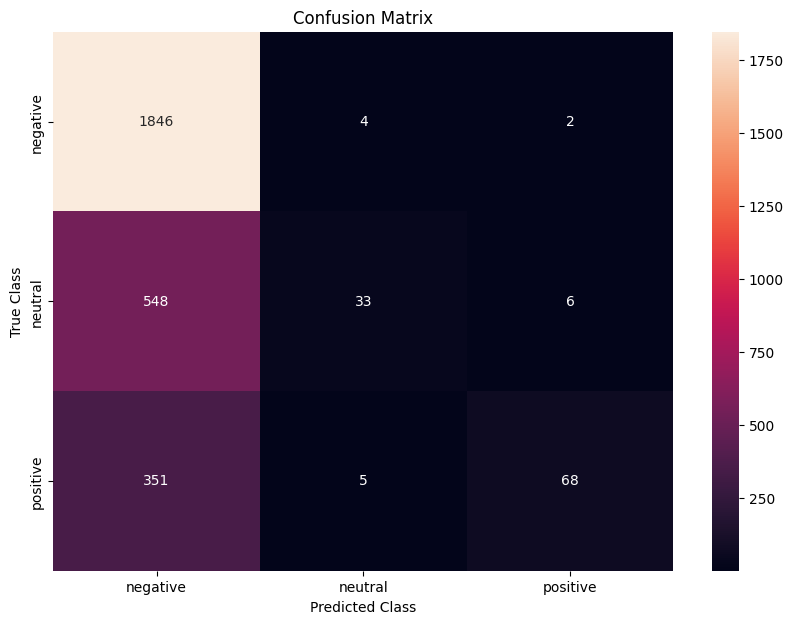

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = le.classes_


# Assuming y_test_rf and y_pred_rf are your true labels and predictions
cm = confusion_matrix(y_test_rf, y_pred_rf)

# Plotting using seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()


In [ ]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

In [ ]:
import cuml
from cuml.ensemble import RandomForestClassifier
from cuml.model_selection import train_test_split
from cuml.metrics import accuracy_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# Vectorize the cleaned text data
tfidf = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
X_vectorized = tfidf.fit_transform(my_data['cleaned_text']).toarray()

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(my_data['airline_sentiment'])
# Assuming X and y are your feature matrix and labels and are already on GPU
# If not, you'll need to transfer them to GPU
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_vectorized, y_encoded, test_size=0.2)

# Random Forest model
rf = RandomForestClassifier(n_estimators=100, max_depth=20)

# Train the model (it will use the GPU automatically)
rf.fit(X_train_rf, y_train_rf)

# Make predictions
y_pred = rf.predict(X_test_rf)

# Calculate accuracy
acc = accuracy_score(y_test_rf, y_pred)
print("Accuracy:", acc)


/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Accuracy: 0.6473481059074402


In [ ]:
from sklearn.metrics import classification_report

# Best Random Forest model
best_rf = grid_search.best_estimator_

# Predictions on the test set
y_pred_rf = best_rf.predict(X_test_rf)

# Classification report
print(classification_report(y_test_rf, y_pred_rf))

# Best parameters
print("Best parameters found: ", grid_search.best_params_)


In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()